In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('../train_data_hand-gestures.csv')
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X.shape ,y.shape

((27455, 784), (27455,))

In [3]:
num_classes = len(np.unique(y))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.astype('float32') / 255.0
#X_val = X_val.astype('float32') / 255.0

X_train = X_train.reshape((-1, 28, 28, 1)).astype('float32')
X_val = X_val.reshape((-1, 28, 28, 1)).astype('float32')

# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes+1)
y_val = tf.keras.utils.to_categorical(y_val, num_classes+1)

In [11]:
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.optimizers import Adam

class BlockDropout(layers.Layer):
    def __init__(self, drop_rate=0.5, **kwargs):
        super(BlockDropout, self).__init__(**kwargs)
        self.drop_rate = drop_rate

    def call(self, inputs, training=None):
        if not training:
            return inputs
        keep_prob = 1.0 - self.drop_rate
        shape = tf.shape(inputs)
        random_tensor = keep_prob
        random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
        binary_tensor = tf.floor(random_tensor)
        output = tf.divide(inputs, keep_prob) * binary_tensor
        return output

model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(BlockDropout(drop_rate=0.5)) 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(BlockDropout(drop_rate=0.5)) 
#model.add(DropBlock2D(0.1, block_size=7))
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
#model.add(BlockDropout(drop_rate=0.5)) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes+1, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy',  metrics=['accuracy'])

model.summary()

print(X_train.shape, y_train.shape)
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_val, y_val))
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_dropout_2 (BlockDropout)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_dropout_3 (BlockDropout)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,289 (481.60 KB)

 Trainable params: 123,097 (480.85 KB)

 Non-trainable params: 192 (768.00 B)

(21964, 28, 28, 1) (21964, 25)
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.0664 - loss: 3.9821 - val_accuracy: 0.0998 - val_loss: 3.0820
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.1760 - loss: 2.8114 - val_accuracy: 0.1240 - val_loss: 6.6234
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.2890 - loss: 2.3253 - val_accuracy: 0.3681 - val_loss: 3.3535
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.3852 - loss: 1.9023 - val_accuracy: 0.5345 - val_loss: 3.0816
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.4798 - loss: 1.5572 - val_accuracy: 0.4939 - val_loss: 7.2670
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.5603 - loss: 1.3058 - val_accuracy: 0.6804 - val_loss: 4.3688
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.6287 - loss: 1.0795 - val_accuracy: 0.7164 - val_loss: 4.2693
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0

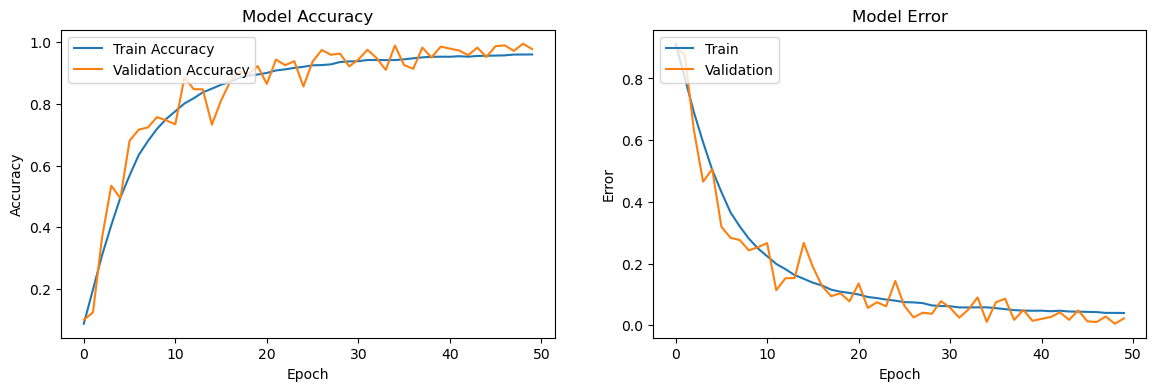

In [13]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

train_error = 1 - np.array(history.history['accuracy'])
val_error = 1 - np.array(history.history['val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(train_error, label='Train Error')
plt.plot(val_error, label='Validation Error')
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('cnn2', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
df_test = pd.read_csv('../test_data_hand-gestures.csv')
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values
X_test = X_test.astype('float32') / 255.0
X_test = X_test.reshape((-1, 28, 28, 1)).astype('float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes+1)
X_test.shape ,y_test.shape


((7172, 28, 28, 1), (7172, 25))

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9541 - loss: 0.1600


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


<Figure size 640x480 with 0 Axes>

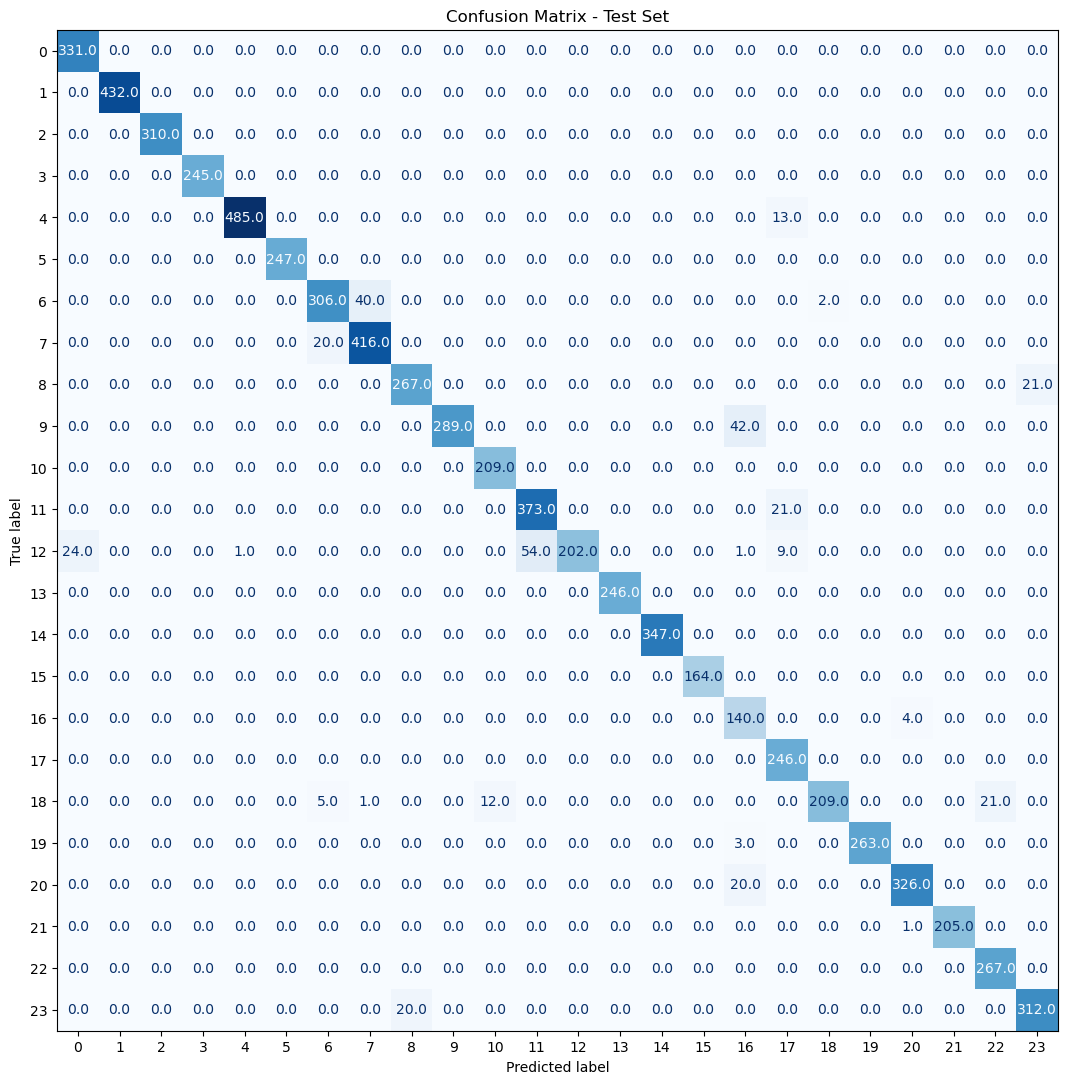

<Figure size 1300x1300 with 0 Axes>

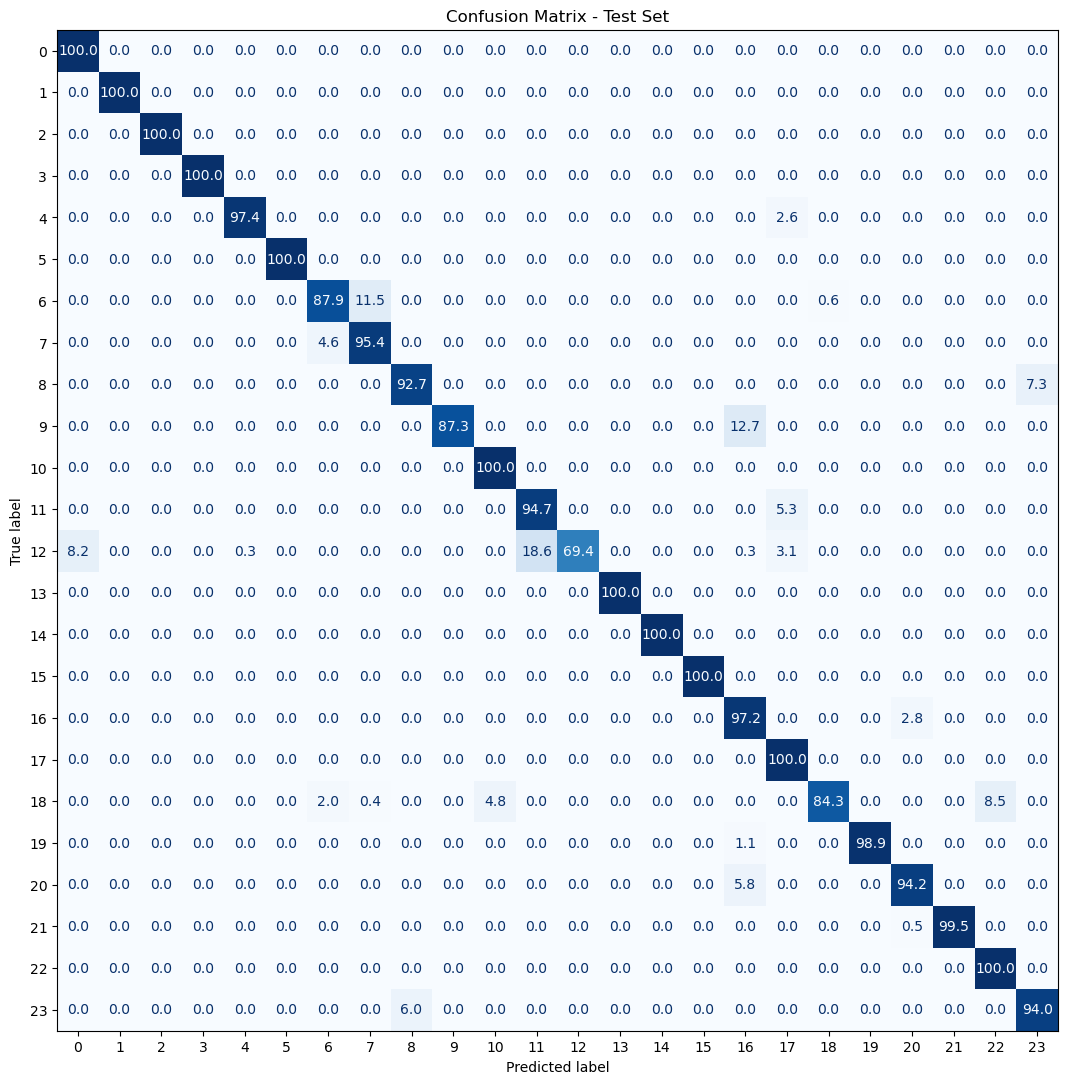

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

cm_test = confusion_matrix(y_test_argmax, y_test_pred_classes)
cm_test_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
plt.rcParams['figure.figsize'] = [13, 13]
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=np.arange(24))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.savefig('cnn2 cm', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.rcParams['figure.figsize'] = [13, 13]
disp_test = ConfusionMatrixDisplay(cm_test_percent, display_labels=np.arange(24))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.show()